## Rod Cantilever Example

In [75]:
import numpy as np
import time
import dismech

geom = dismech.GeomParams(
    rod_r0=2e-2,
    shell_h=0.0,
)

material = dismech.Material(density=1000,
                            youngs_rod=1e7,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

static_2d_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=True,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=10.0,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
env.add_force('viscous', eta=5e-2)

geo = dismech.Geometry.from_txt(
    '../tests/resources/rod_cantilever/horizontal_rod_n51.txt')

robot = dismech.SoftRobot(geom, material, geo, static_2d_sim, env)

In [76]:
print(robot.q0[robot.map_node_to_dof(5)])

[ 0.01 -0.   -0.  ]


### Time Stepping

As we are performing a static simulation, we must change gravity for each time step.

In [77]:
fixed_points = np.array([0, 1])

robot = robot.fix_nodes(fixed_points)
stepper = dismech.NewmarkBetaTimeStepper(robot)

start = time.time()
robots = stepper.simulate()
end = time.time()

qs = np.stack([robot.state.q for robot in robots])

In [78]:
print(end-start)

6.006873846054077


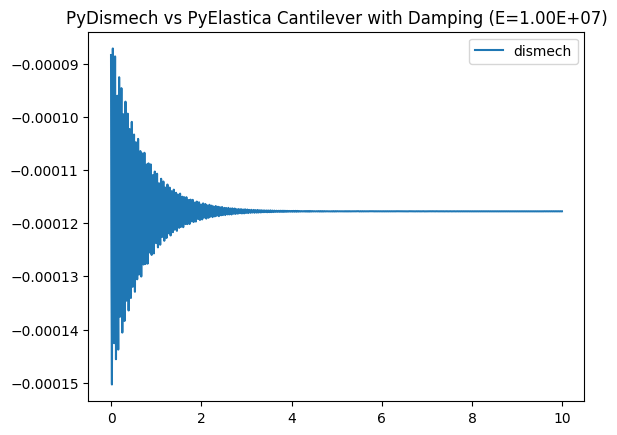

In [82]:
import matplotlib.pyplot as plt
if material.youngs_rod == 1e5:
    file = 'cantilever_E=1e5_dt=9e-5.npz'
if material.youngs_rod == 1e6:
    file = 'cantilever_E=1e6_dt=3e-5.npz'
if material.youngs_rod == 1e7:
    file = 'cantilever_E=1e7_dt=9e-6.npz'
elastica = np.load(file)
t = np.arange(0, robot.sim_params.total_time, robot.sim_params.dt)
plt.plot(t, qs[:, robot.end_node_dof_index - 1], label='dismech')
#plt.plot(elastica['time'], elastica['position'][:, 2, -1], label='elastica')
plt.title("PyDismech vs PyElastica Cantilever with Damping (E={:.2E})".format(material.youngs_rod))
plt.legend()
plt.show()

In [80]:
import numpy as np

# Constants and parameters
Y = material.youngs_rod  # Young's modulus in Pascals
L = 0.1 - 0.1/100  # Length in meters
r = 2e-2  # Radius in meters
rho = 1000  # Density in kg/m^3

A = np.pi * r**2  # Cross-sectional area
mass = rho * L * A
mperL = rho * A  # Mass per unit length
g = -9.81  # Gravitational acceleration in m/s^2

I = (np.pi * r**4) / 4  # Moment of inertia for a solid cylinder
alpha1 = 1.875**2

omega_n = alpha1 * np.sqrt(Y * I / (mperL * L**4))  # Natural frequency in rad/s
f = omega_n / (2 * np.pi)  # Frequency in Hz
Time_period = 1 / f  # Time period in seconds

mean_disp_tip = mass * g * L**3 / (8 * Y * I)  # Mean displacement at the tip in meters


In [81]:
print('Dismech: {:.4e}'.format(qs[-1, robot.end_node_dof_index-1]))
print('Elastica: {:.4e}'.format(elastica['position'][-1, 2, -1]))
print(f"Analytical: {mean_disp_tip:.4e}")


Dismech: -1.1777e-04
Elastica: -1.3045e-04
Analytical: -1.1779e-04
